# HABERMAN SURVIVAL

El conjunto de datos de Haberman es relativamente conocido. A menudo se utiliza en entornos académicos y en competencias de ciencia de datos para practicar tareas de clasificación binaria, ya que implica predecir el estado de supervivencia en función de la edad del paciente, el año de la operación y el número de nódulos axilares positivos detectados.

La simplicidad del conjunto de datos y su contexto médico del mundo real lo convierten en una herramienta útil para aprender y demostrar diversas técnicas de aprendizaje automático, particularmente en el manejo de conjuntos de datos desequilibrados y en la realización de análisis exploratorio de datos.

In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src.DataPreparer import DataPreparer
from src.FormalContext import FormalContext
from src.OtherModels import *
from src import FCADecisionTree as FCADtree

import pandas as pd

DATA_CSV_FILE_PATH = 'C:\\Users\\Focus\\Desktop\\TFG\\TFG\\fca-decision-tree-classifier\\datasets\\real_datasets\\haberman_survival.csv'
TREES_MAX_DEPTH = 4

df = pd.read_csv(DATA_CSV_FILE_PATH)
df.describe()


,Age,Year,PositiveNodes,SurvivalStatus
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             306 non-null    int64
 1   Year            306 non-null    int64
 2   PositiveNodes   306 non-null    int64
 3   SurvivalStatus  306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


In [3]:
df

,Age,Year,PositiveNodes,SurvivalStatus
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1
...,...,...,...,...
301,75,62,1,1
302,76,67,0,1
303,77,65,3,1
304,78,65,1,2


# Prueba inicial del árbol básico c4.5, obtención de sus umbrales

In [4]:
from src.DecisionTreeC45 import DecisionTreeC45
from sklearn.model_selection import train_test_split

data = df.copy()
taget_column = -1

X = data.iloc[:, :-1]  # Todas las columnas excepto la última
y = data.iloc[:, -1]   # La última columna

# Convertir X a una lista de listas y y a una lista
X_list = X.values.tolist()
y_list = y.values.tolist()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_list, y_list, test_size=0.2, random_state=42)

# Entrenar el modelo de árbol de decisión C4.5
attribute_names = X.columns.tolist()

decision_tree_c45 = DecisionTreeC45(attribute_names=attribute_names, max_depth=TREES_MAX_DEPTH)
decision_tree_c45.train_tree(X_train, y_train)


predictions_treec45 = decision_tree_c45.classify_instances(X_test)

decision_tree_c45.evaluation_metrics(y_test, predictions_treec45, average='macro') 
decision_tree_c45.print_tree_structure()

# Obtener los umbrales de los atributos continuos
thresholds = decision_tree_c45.get_thresholds()

print("Umbrales de los atributos continuos:", thresholds)

Accuracy: 0.6774193548387096
Precision: 0.5653846153846154
Recall: 0.5429292929292929
F1 Score: 0.5386904761904762
Confusion Matrix:
[[38  6]
 [14  4]]
Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.86      0.79        44
           2       0.40      0.22      0.29        18

    accuracy                           0.68        62
   macro avg       0.57      0.54      0.54        62
weighted avg       0.63      0.68      0.64        62

Attribute: Age <= 77.0
  Attribute: PositiveNodes <= 49.0
    Attribute: PositiveNodes <= 8.5
      Attribute: Age <= 38.5
        Decision: 1
        Decision: 1
      Attribute: Year <= 68.5
        Decision: 2
        Decision: 1
    Decision: 2
  Decision: 2
Umbrales de los atributos continuos: {0: [77.0, 38.5], 2: [49.0, 8.5], 1: [68.5]}


# Preparado de los datos, utilización de los mismos umbrales del C4.5

In [5]:
data_preparer = DataPreparer()
data_preparer.prepare_csvfile_data(
    file_path=DATA_CSV_FILE_PATH,
    discretizing_thresholds=thresholds  # Pasar los umbrales obtenidos del modelo C4.5
)

X_train, X_test, y_train, y_test = data_preparer.get_train_test_split_data_binarized()
labeled_train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)

objects = list(labeled_train_data.index)
properties = [prop for prop in labeled_train_data.columns if prop != 'objective_target']
num_objects = len(objects)
num_properties = len(properties)

print(f"Number of Objects: {num_objects}")
print(f"Number of Properties-Attributes: {num_properties}")

labeled_train_data.info()

Number of Objects: 231
Number of Properties-Attributes: 8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age_0             231 non-null    float64
 1   Age_1             231 non-null    float64
 2   Age_2             231 non-null    float64
 3   Year_0            231 non-null    float64
 4   Year_1            231 non-null    float64
 5   PositiveNodes_0   231 non-null    float64
 6   PositiveNodes_1   231 non-null    float64
 7   PositiveNodes_2   231 non-null    float64
 8   objective_target  231 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 16.4 KB


# Computación del contexto formal y prueba del árbol FCA:

Tamaño máximo del contexto: 1848
Tiempo de ejecución para el retículo: 0.00 segundos

Finalizando Algoritmo:
Número de conceptos formales: 25

Vector a clasificar:  ['Age_1', 'Year_0', 'PositiveNodes_0']
└──Nivel 0: Nodo actual (Intent: [], Label: ROOT), Mejor coincidencia (Intent: [1])
Resultado final: Nodo (Intent: [1], Label: 1)

Vector a clasificar:  ['Age_1', 'Year_0', 'PositiveNodes_0']
└──Nivel 0: Nodo actual (Intent: [], Label: ROOT), Mejor coincidencia (Intent: [1])
Resultado final: Nodo (Intent: [1], Label: 1)

Vector a clasificar:  ['Age_1', 'Year_0', 'PositiveNodes_0']
└──Nivel 0: Nodo actual (Intent: [], Label: ROOT), Mejor coincidencia (Intent: [1])
Resultado final: Nodo (Intent: [1], Label: 1)

Vector a clasificar:  ['Age_1', 'Year_0', 'PositiveNodes_0']
└──Nivel 0: Nodo actual (Intent: [], Label: ROOT), Mejor coincidencia (Intent: [1])
Resultado final: Nodo (Intent: [1], Label: 1)

Vector a clasificar:  ['Age_1', 'Year_0', 'PositiveNodes_1']
└──Nivel 0: Nodo actual (Int

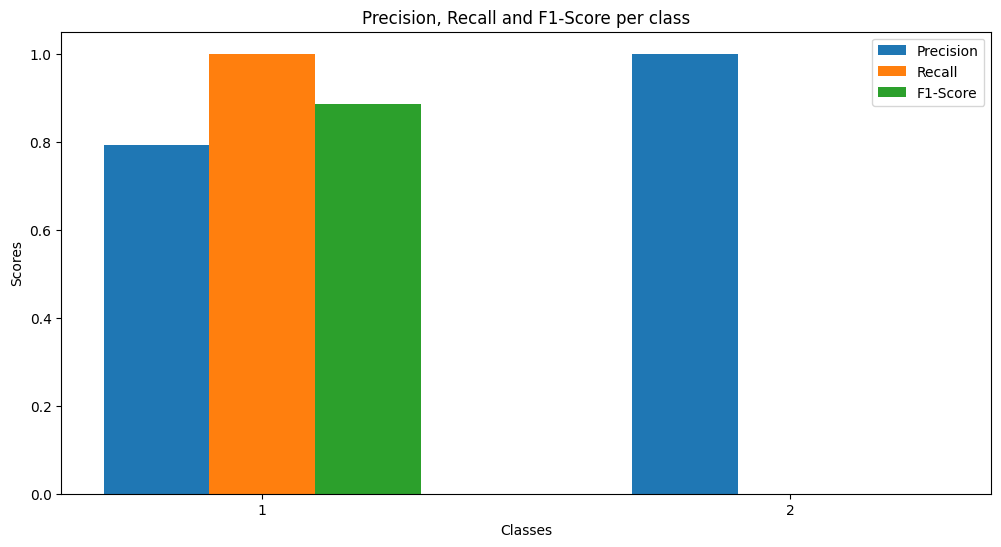

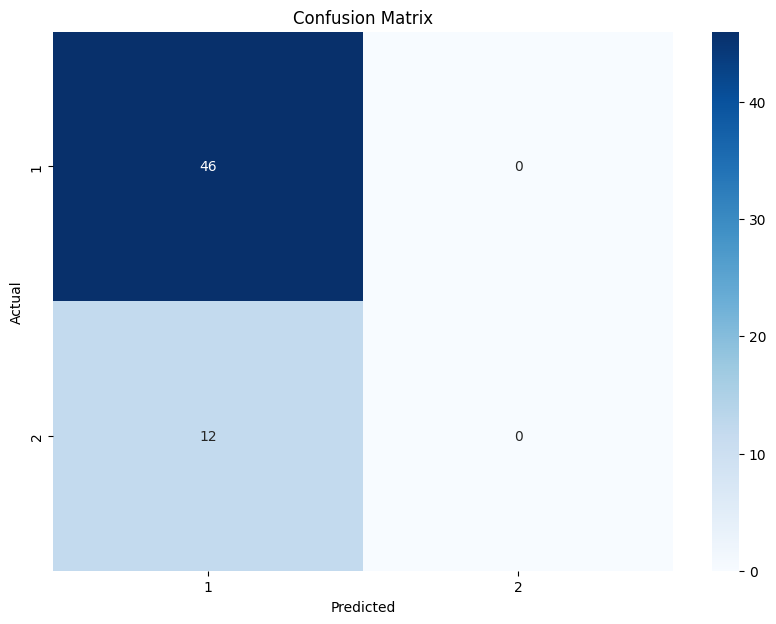

Execution Time: 0.26401734352111816 seconds
--------------------------------------------------
└── [0 - class-label: ROOT]
│   └── [1 - class-label: 1]
│   └── [10 - class-label: 1]
│   └── [18 - class-label: 1]
│   └── [21 - class-label: 1]
│   │   └── [5 - class-label: 2]
│   │   │   └── [6 - class-label: 1]
│   │   │   └── [7 - class-label: 2]
│   │   └── [22 - class-label: 1]
│   └── [23 - class-label: 1]
│   └── [24 - class-label: 2]
{'Tree Depth': 3, 'Total Nodes': 11, 'Leaf Nodes': 8, 'Average inmediate_subconcepts per Node': 0.75}
{'Accuracy': 0.7931034482758621, 'Precision': {1: 0.7931034482758621, 2: 1.0}, 'Recall': {1: 1.0, 2: 0.0}, 'F1-Score': {1: 0.8846153846153846, 2: 0.0}, 'Confusion Matrix': array([[46,  0],
       [12,  0]], dtype=int64)}


In [6]:
formal_context = FormalContext(labeled_data=labeled_train_data)
max_context_size = num_objects * num_properties
print(f"Tamaño máximo del contexto: {formal_context.max_context_size}")  
formal_context.build_lattice(debug=True, compute_parents_childs=True)

print("\nFinalizando Algoritmo:")
print("Número de conceptos formales:", len(formal_context.get_all_concepts_lattice()))

start_time = time.time()
decision_treeFCA = FCADtree.FCADecisionTree(formal_context=formal_context, max_depth=TREES_MAX_DEPTH)
results = decision_treeFCA.evaluate(X_test, y_test, debug=True, plot_results=True)
end_time = time.time()

# Imprimir el tiempo de ejecución
print(f"Execution Time: {end_time - start_time} seconds")
print("--------------------------------------------------")
#decision_treeFCA.print_tree_complete()
decision_treeFCA.print_tree_logic() 
complexity_info = decision_treeFCA.display_tree_complexity()
print(complexity_info)
print(results) 

# Prueba del árbol básico ID3

In [7]:
# Evaluación del modelo DecisionTreeID3
from src.DecisionTreeID3 import DecisionTreeID3

decision_treeid3 = DecisionTreeID3(attribute_names=properties, max_depth=TREES_MAX_DEPTH)

decision_treeid3.train_tree(data_preparer.X_train.values.tolist(), data_preparer.y_train.tolist())

predictions_treeid3 = decision_treeid3.classify_instances(X_test.values.tolist())

decision_treeid3.evaluation_metrics(y_test, predictions_treeid3, average='macro')
decision_treeid3.print_tree_structure()


Accuracy: 0.7931034482758621
Precision: 0.6770833333333333
Recall: 0.6539855072463768
F1 Score: 0.6634429400386848
Confusion Matrix:
[[41  5]
 [ 7  5]]
Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.89      0.87        46
           2       0.50      0.42      0.45        12

    accuracy                           0.79        58
   macro avg       0.68      0.65      0.66        58
weighted avg       0.78      0.79      0.79        58

Attribute: PositiveNodes_0
Category: 0.0
  Attribute: Age_0
  Category: 0.0
    Attribute: PositiveNodes_1
    Category: 0.0
      Decision: 2
    Category: 1.0
      Decision: 2
  Category: 1.0
    Attribute: Year_0
    Category: 0.0
      Decision: 2
    Category: 1.0
      Decision: 1
Category: 1.0
  Attribute: Age_0
  Category: 0.0
    Attribute: Age_1
    Category: 0.0
      Decision: 2
    Category: 1.0
      Attribute: Year_0
      Category: 0.0
        Decision: 1
      Category: 1.0
 

Prueba de cross-validación:

In [8]:
decision_treeid3.test_CV(X, y, random_state=42, attribute_names=attribute_names, k=5, max_depth=4)

Exactitud media: 0.7027
Precisión media: 0.5134
Recall media: 0.5119
F1-Score media: 0.4839
Desviación estándar de la Exactitud: 0.0357


# Prueba adicional de los demás modelos

Prueba con preprocesamiento, discretizados y binarizados:

In [9]:
CROSS_VALIDATION = 1
METRICS_AVERAGE = 'weighted'

tryOtherModels(X_train, X_test, y_train, y_test, CROSS_VALIDATION, selected_average=METRICS_AVERAGE)

Evaluating model: Logistic Regression
Classifier: OneVsRestClassifier
Accuracy: 0.7758620689655172
Precision: 0.7555711939948394
Recall: 0.7758620689655172
F1 Score: 0.7633912367124708
Confusion Matrix:
[[41  5]
 [ 8  4]]
Execution Time: 0.018048763275146484 seconds
--------------------------------------------------
Evaluating model: SVM
Classifier: SVC
Accuracy: 0.7931034482758621
Precision: 0.7808908045977011
Recall: 0.7931034482758621
F1 Score: 0.78590008670713
Confusion Matrix:
[[41  5]
 [ 7  5]]
Execution Time: 0.014300346374511719 seconds
--------------------------------------------------
Evaluating model: Decision Tree
Classifier: DecisionTreeClassifier
Accuracy: 0.7931034482758621
Precision: 0.7808908045977011
Recall: 0.7931034482758621
F1 Score: 0.78590008670713
Confusion Matrix:
[[41  5]
 [ 7  5]]
Execution Time: 0.012530088424682617 seconds
--------------------------------------------------
Evaluating model: K-Nearest Neighbors
Classifier: KNeighborsClassifier
Accuracy: 0.77

Prueba sin preprocesamiento, con los datos originales

In [10]:
CROSS_VALIDATION = 1
METRICS_AVERAGE = 'weighted'

data = df.copy()
taget_column = -1

X = data.iloc[:, :-1]  
y = data.iloc[:, -1]   

X_list = X.values.tolist()
y_list = y.values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X_list, y_list, test_size=0.2, random_state=42)

tryOtherModels(X_train, X_test, y_train, y_test, CROSS_VALIDATION, selected_average=METRICS_AVERAGE)

Evaluating model: Logistic Regression
Classifier: OneVsRestClassifier
Accuracy: 0.6935483870967742
Precision: 0.6405529953917051
Recall: 0.6935483870967742
F1 Score: 0.6431541218637993
Confusion Matrix:
[[40  4]
 [15  3]]
Execution Time: 0.016522884368896484 seconds
--------------------------------------------------
Evaluating model: SVM
Classifier: SVC
Accuracy: 0.6935483870967742
Precision: 0.5002644103648863
Recall: 0.6935483870967742
F1 Score: 0.5812596006144394
Confusion Matrix:
[[43  1]
 [18  0]]
Execution Time: 0.010514497756958008 seconds
--------------------------------------------------
Evaluating model: Decision Tree
Classifier: DecisionTreeClassifier
Accuracy: 0.6612903225806451
Precision: 0.6446122168840083
Recall: 0.6612903225806451
F1 Score: 0.6514775547033612
Confusion Matrix:
[[35  9]
 [12  6]]
Execution Time: 0.006524801254272461 seconds
--------------------------------------------------
Evaluating model: K-Nearest Neighbors
Classifier: KNeighborsClassifier
Accuracy: 

# TEST ESTADÍSTICO DEL FCATREE CON EL ID3 Y  EL C4.5

## Parámetros globales:

In [11]:
CLASSES_THRESHOLD = 0.6 # % de similitud de clases para la poda en el FCATREE
debug=False
max_depth = 5
random_state = 42
test_size = 0.3


OTHER_TREE_MODEL = "ID3" #primera prueba con el ID3

## Definición de funciones

In [12]:
import numpy as np
import pandas as pd
from scipy import stats
from mlxtend.evaluate import mcnemar_table, mcnemar
from scipy.stats import t as t_dist
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# test t de paridad
def paired_t_test(p):
        p_hat = np.mean(p)
        n = len(p)
        den = np.sqrt(sum([(diff - p_hat)**2 for diff in p]) / (n - 1))
        t = (p_hat * (n**(1/2))) / den
        
        p_value = t_dist.sf(t, n-1)*2
        
        return t, p_value

# PRUEBA DE TEST Z PARA DOS PORPORCIONES
def two_proportions_test(y_true, y_pred1, y_pred2):
    success_a = np.sum(y_pred1 == y_true)
    success_b = np.sum(y_pred2 == y_true)
    n_a = len(y_true)
    n_b = len(y_true)
    
    prop_a = success_a / n_a
    prop_b = success_b / n_b
    
    var_a = (prop_a * (1 - prop_a)) / n_a
    var_b = (prop_b * (1 - prop_b)) / n_b
    
    if var_a + var_b == 0:
        return 0, 1  # No hay diferencia significativa si no hay variabilidad
    
    z = (prop_a - prop_b) / np.sqrt(var_a + var_b)
    p_value = stats.norm.sf(abs(z)) * 2  # Test de dos colas
    
    return z, p_value

# PRUEBA DE MCNEMAR
def mcnemar_test(y_true, y_pred1, y_pred2):
    table = mcnemar_table(y_target=np.array(y_true), 
                          y_model1=np.array(y_pred1), 
                          y_model2=np.array(y_pred2))
    chi2, p = mcnemar(ary=table, corrected=True)
    return chi2, p

# PRUEBA T PAREADA
def resampled_paired_ttest(data_preparer, n_tests=30, test_size=None, max_depth=None):
    global random_state, OTHER_TREE_MODEL, CLASSES_THRESHOLD, debug
    p_ = []
    rng = np.random.RandomState(random_state)
    for i in range(n_tests):
        randint = rng.randint(low=0, high=32767)
        X_train, X_test, y_train, y_test = data_preparer.get_train_test_split_data_binarized(random_state=randint, test_size=test_size)

        # para el modelo FCA
        labeled_train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
        formal_context = FormalContext(labeled_data=labeled_train_data)
        formal_context.build_lattice(debug=False, compute_parents_childs=True)
        fca_model = FCADtree.FCADecisionTree(formal_context=formal_context, max_depth=max_depth, classes_threshold=CLASSES_THRESHOLD)
        
        # para el otro modelo ID3
        properties = [prop for prop in labeled_train_data.columns if prop != 'objective_target']

        if(OTHER_TREE_MODEL == "C45"):
            other_tree_model = DecisionTreeC45(attribute_names=properties, max_depth=max_depth)
        else:
            other_tree_model = DecisionTreeID3(attribute_names=properties, max_depth=max_depth)


        other_tree_model.train_tree(data_preparer.X_train.values.tolist(), data_preparer.y_train.tolist())

        
        accuracy = accuracy_score(y_test, fca_model.classify_instances(X_test))
        if(debug):
            print("FCAMODEL: ", accuracy)
        accuracy = accuracy_score(y_test, other_tree_model.classify_instances(X_test.values.tolist()))
        if(debug):
            print("OTHER: ", accuracy)
        

        acc1 = accuracy_score(y_test, fca_model.classify_instances(X_test))
        acc2 = accuracy_score(y_test, other_tree_model.classify_instances(X_test.values.tolist()))
        p_.append(acc1 - acc2)

    t_stat, p_value = paired_t_test(p_)
    return t_stat, p_value



# CV DE 5 ITERACIONES DE 2 PLIEGUES
def cross_val_5x2_test(data_preparer, test_size, max_depth):
    global random_state, OTHER_TREE_MODEL, CLASSES_THRESHOLD,  debug

    def five_two_statistic(p1, p2):
        p1 = np.array(p1)
        p2 = np.array(p2)
        p_hat = (p1 + p2) / 2
        s = (p1 - p_hat)**2 + (p2 - p_hat)**2
        t = p1[0] / np.sqrt(1/5. * sum(s))
        
        p_value = t_dist.sf(t, 5)*2
        
        return t, p_value

    p_1 = []
    p_2 = []

    rng = np.random.RandomState(42)
    for i in range(5):
        randint = rng.randint(low=0, high=32767)
        X_train, X_test, y_train, y_test = data_preparer.get_train_test_split_data_binarized(debug=debug, random_state=randint, test_size=test_size)

        # p1 evaluacion de train-test
            # para el modelo FCA
        labeled_train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
        formal_context = FormalContext(labeled_data=labeled_train_data)
        formal_context.build_lattice(debug=False, compute_parents_childs=True)
        fca_model = FCADtree.FCADecisionTree(formal_context=formal_context, max_depth=max_depth, classes_threshold=CLASSES_THRESHOLD)
        
            # para el otro modelo ID3
        properties = [prop for prop in labeled_train_data.columns if prop != 'objective_target']

        if(OTHER_TREE_MODEL == "C45"):
            other_tree_model = DecisionTreeC45(attribute_names=properties, max_depth=max_depth)
        else:
            other_tree_model = DecisionTreeID3(attribute_names=properties, max_depth=max_depth)


        other_tree_model.train_tree(data_preparer.X_train.values.tolist(), data_preparer.y_train.tolist())


        acc1 = accuracy_score(y_test, fca_model.classify_instances(X_test))
        acc2 = accuracy_score(y_test, other_tree_model.classify_instances(X_test.values.tolist()))
        p_1.append(acc1 - acc2)


        # p2 evaluacion de test-train
            # para el modelo FCA
        labeled_train_data = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)
        formal_context = FormalContext(labeled_data=labeled_train_data)
        formal_context.build_lattice(debug=False, compute_parents_childs=True)
        fca_model = FCADtree.FCADecisionTree(formal_context=formal_context, max_depth=max_depth, classes_threshold=CLASSES_THRESHOLD)
        
            # para el otro modelo ID3
        properties = [prop for prop in labeled_train_data.columns if prop != 'objective_target']

        if(OTHER_TREE_MODEL == "C45"):
            other_tree_model = DecisionTreeC45(attribute_names=properties, max_depth=max_depth)
        else:
            other_tree_model = DecisionTreeID3(attribute_names=properties, max_depth=max_depth)


        other_tree_model.train_tree(data_preparer.X_test.values.tolist(), data_preparer.y_test.tolist())

        acc1 = accuracy_score(y_train, fca_model.classify_instances(X_train))
        acc2 = accuracy_score(y_train, other_tree_model.classify_instances(X_train.values.tolist()))
        p_2.append(acc1 - acc2)

    t, p = five_two_statistic(p_1, p_2)
    return t, p


def test_statistical(random_state, test_size, max_depth, data_preparer):
    X_train, X_test, y_train, y_test = data_preparer.get_train_test_split_data_binarized(debug=debug, random_state=random_state, test_size=test_size)

    print("#############################################################################")
    if(debug):
        print("\n\n\ESTRUCTURAS de datos de X e Y:\n", X, y, X_train, X_test, y_train, y_test)

    # Inicializar y proabr el modelo FCA
    labeled_train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
    formal_context = FormalContext(labeled_data=labeled_train_data)
    formal_context.build_lattice(debug=False, compute_parents_childs=True)
    print("\nFinalizando Algoritmo del retículo:")
    print("Número de conceptos formales:", len(formal_context.get_all_concepts_lattice()))
    fca_model = FCADtree.FCADecisionTree(formal_context=formal_context, max_depth=max_depth, classes_threshold=CLASSES_THRESHOLD)
    
    if(debug):
        fca_model.print_tree_logic()
        fca_model.print_tree_structure()

    fca_predicted_labels = fca_model.classify_instances(X_test)

    # Inicializar y probar el otro modelo
    properties = [prop for prop in labeled_train_data.columns if prop != 'objective_target']
    
    if(OTHER_TREE_MODEL == "C45"):
        other_tree_model = DecisionTreeC45(attribute_names=properties, max_depth=max_depth)
    else:
        other_tree_model = DecisionTreeID3(attribute_names=properties, max_depth=max_depth)

    other_tree_model.train_tree(data_preparer.X_train.values.tolist(), data_preparer.y_train.tolist())
    predictions_other_tree= other_tree_model.classify_instances(X_test.values.tolist())

    # Two Proportions Test
    z, p_proportions = two_proportions_test(y_test , fca_predicted_labels, predictions_other_tree)
    #print("two_proportions_test:", z, p_proportions)

     # McNemar’s Test
    chi2_mcnemar, p_mcnemar = mcnemar_test(y_test, fca_predicted_labels, predictions_other_tree)
    #print("mcnemar_test", chi2_mcnemar, p_mcnemar)
    
    # Resampled Paired t-test
    t_resampled, p_resampled = resampled_paired_ttest(data_preparer, n_tests=30, test_size=test_size, max_depth=max_depth)
    #print("resampled_paired_ttest", t_resampled, p_resampled)

    
    # 5x2 Cross-Validation Test
    t_5x2, p_5x2 = cross_val_5x2_test(data_preparer, test_size, max_depth)
    #print("cross_val_5x2_test", t_5x2, p_5x2)
    
    results = {
        "Two Proportions Test": (z, p_proportions),
        "McNemars Test": (chi2_mcnemar, p_mcnemar),
        "Resampled Paired t-test": (t_resampled, p_resampled),
        "5x2 Cross-Validation Test": (t_5x2, p_5x2)
    }
    
    return results


print(f"Parámetros de configuración:")
print(f"Umbral de similitud de clases para la poda (CLASSES_THRESHOLD): {CLASSES_THRESHOLD}")
print(f"Umbrales de los atributos continuos usados en la discretización como en el c4.5:  {thresholds}")
print(f"Profundidad máxima del árbol (max_depth): {max_depth}")
print(f"Estado aleatorio (random_state): {random_state}")
print(f"Tamaño del conjunto de prueba (test_size): {test_size}")

Parámetros de configuración:
Umbral de similitud de clases para la poda (CLASSES_THRESHOLD): 0.6
Umbrales de los atributos continuos usados en la discretización como en el c4.5:  {0: [77.0, 38.5], 2: [49.0, 8.5], 1: [68.5]}
Profundidad máxima del árbol (max_depth): 5
Estado aleatorio (random_state): 42
Tamaño del conjunto de prueba (test_size): 0.3


## Prueba con el ID3

In [13]:
# Comparación estadística
# Entre FCADecisionTree y DecisionTreeID3
results_with_id3 = test_statistical(random_state, test_size, max_depth, data_preparer)

print("\nResultados entre y and DecisionTreeID3:")
for test_name, (statistic, p_value) in results_with_id3.items():
    print(f"{test_name}: Statistic = {statistic}, p-value = {p_value}")


#############################################################################

Finalizando Algoritmo del retículo:
Número de conceptos formales: 25

Resultados entre y and DecisionTreeID3:
Two Proportions Test: Statistic = -0.5806972553108725, p-value = 0.561444511885846
McNemars Test: Statistic = 0.3076923076923077, p-value = 0.5790997419539188
Resampled Paired t-test: Statistic = -4.68709984021277, p-value = 1.9999395142967011
5x2 Cross-Validation Test: Statistic = -0.02850101305536636, p-value = 1.0216348357303469


## Prueba con el C4.5

In [14]:
OTHER_TREE_MODEL = "C45"

# Comparación estadística
# Entre FCADecisionTree y DecisionTreeC45
results_with_c45 = test_statistical(random_state, test_size, max_depth, data_preparer)
print("\nResults between FCADecisionTree and DecisionTreeC45:")
for test_name, (statistic, p_value) in results_with_c45.items():
    print(f"{test_name}: Statistic = {statistic}, p-value = {p_value}")


#############################################################################

Finalizando Algoritmo del retículo:
Número de conceptos formales: 25

Results between FCADecisionTree and DecisionTreeC45:
Two Proportions Test: Statistic = -0.5806972553108725, p-value = 0.561444511885846
McNemars Test: Statistic = 0.3076923076923077, p-value = 0.5790997419539188
Resampled Paired t-test: Statistic = -4.535619649499973, p-value = 1.9999079870236147
5x2 Cross-Validation Test: Statistic = -0.028482955941576654, p-value = 1.0216211332032148
